### Setup for path variable to connect to DB

In [4]:
import sys
import os

_path_added = False

def add_project_root_to_path():
    """
    Check if the project root directory is in the Python path.
    If not, add it to sys.path and change the working directory to the project root.
    """
    global _path_added

    if _path_added:
        return
    
    root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

    if root_dir not in sys.path:
        sys.path.append(root_dir)
        print(f"Added {root_dir} to Python path.")
    
    if os.getcwd() != root_dir:
        os.chdir(root_dir)
        print(f"Changed working directory to {root_dir}.")
    _path_added = True


add_project_root_to_path()

Added /home/developing_nacho/fhdw/web_social_analytics/dj-gpt/insta_scraping to Python path.
Changed working directory to /home/developing_nacho/fhdw/web_social_analytics/dj-gpt/insta_scraping.


### Setup connection and session to SQLite DB

In [5]:
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from dorfterror_database.database_structure import Base, Post, Profile
from pathlib import Path

root_path = Path(".").resolve()
print(root_path)

engine = create_engine(f"sqlite:///{root_path}/dorfterror_database/dorfterror.db")
Base.metadata.create_all(engine)

Session = sessionmaker(bind=engine)
session = Session()

/home/developing_nacho/fhdw/web_social_analytics/dj-gpt/insta_scraping


### Get Posts from DB

In [6]:
total_posts = session.query(Post).count()

# Top 25% erfolgreichste Posts
top_posts = (
    session.query(Post)
    .order_by(Post.like_count.desc())
    #.limit( int(total_posts * 0.25) )
    .all()
)

print(top_posts)
print(f"Anzahl der Posts: {len(top_posts)}")

[<dorfterror_database.database_structure.Post object at 0x7c6f8c922060>, <dorfterror_database.database_structure.Post object at 0x7c6f8c922000>, <dorfterror_database.database_structure.Post object at 0x7c6f8c921310>, <dorfterror_database.database_structure.Post object at 0x7c6f8c9220c0>, <dorfterror_database.database_structure.Post object at 0x7c6f8c9220f0>, <dorfterror_database.database_structure.Post object at 0x7c6f8c922150>, <dorfterror_database.database_structure.Post object at 0x7c6f8c9221b0>, <dorfterror_database.database_structure.Post object at 0x7c6f8c9221e0>, <dorfterror_database.database_structure.Post object at 0x7c6f8c922210>, <dorfterror_database.database_structure.Post object at 0x7c6f8c922240>, <dorfterror_database.database_structure.Post object at 0x7c6f8c9222a0>, <dorfterror_database.database_structure.Post object at 0x7c6f8c922300>, <dorfterror_database.database_structure.Post object at 0x7c6f8c922330>, <dorfterror_database.database_structure.Post object at 0x7c6f8c

### Setup Client to LM Studio

In [4]:
from openai import OpenAI

# Initialize LM Studio client
client = OpenAI(base_url="http://192.168.178.85:1200/v1", api_key="lm-studio")
MODEL = "google/gemma-3-12b"


#### Function for asking the LLM to categorize the Posts

In [5]:
def get_categories(post):
    """
    Get categories for a post using the LM Studio client.
    """
    response = client.chat.completions.create(
        model=MODEL,
        messages=[
            {
                "role": "system",
                "content": "Du bist eine Expertin darin, Instagram-Posts anhand ihres Inhalts zu kategorisieren. Diese Kategorien kannst du verwenden: „Musik & Releases“ (für z.B. neue Musik, Song-Hintergründe, Musikvideos oder Studio-Sessions), „Live & Tour“ (für z.B. Tourdaten, Konzertankündigungen, Fotos und Videos nach Auftritten oder Backstage/Behind-the-scenes Inhalte), „Bandalltag“ (für z.B. Proberaum-Szenen, Mitglieder vorstellen oder Throwbacks und Jubiläumsposts), „Politisches Engagement“ (für z.B. politische Themen und gesellschaftskritische Beiträge), „Merchandise“ (für z.B. Verlinkungen zum Shop, Merchandise Ankündigungen oder Rabattaktionen).",
            },
            {
                "role": "user",
                "content": f"Es darf nur eine Kategorie verwendet werden und gib keine Begründung an, sondern nur eine Kategorie. Kategorisiere den folgenden Post: {post.caption}",
            },
        ],
        max_tokens=100,
    )
    
    categories = response.choices[0].message.content.strip()
    return categories

In [11]:
import pandas as pd

post_categories = []

for post in top_posts:
    category = get_categories(post)
    post_categories.append({'post_id': post.id, 'category': category})
    print(f"Post ID: {post.id}, Category {category}")

df = pd.DataFrame(post_categories)
df.to_parquet(f"{root_path}/filtered_datasets/posts_categories.parquet", index=False)

Post ID: 3558420190388657708, Category Politisches Engagement
Post ID: 3354615879621148269, Category Musik & Releases
Post ID: 3484304186725799873, Category Bandalltag
Post ID: 3525759813989560877, Category Bandalltag
Post ID: 3424317889374594372, Category Bandalltag
Post ID: 3428018308341265565, Category Bandalltag
Post ID: 2952710126750917334, Category Politisches Engagement
Post ID: 3525022422026697191, Category Bandalltag
Post ID: 1919143627777337548, Category Live & Tour
Post ID: 3615709126985800120, Category Live & Tour
Post ID: 3497598025804652983, Category Politisches Engagement
Post ID: 3014228045728590247, Category Bandalltag
Post ID: 3150250238614587108, Category Live & Tour
Post ID: 3488011984697305274, Category Bandalltag
Post ID: 3629492663649259897, Category Live & Tour
Post ID: 3411332673173632846, Category Merchandise
Post ID: 3387475397195123646, Category Politisches Engagement
Post ID: 3447628255509007412, Category Live & Tour
Post ID: 3443221890643457929, Category L

### Check categories, group by categories to get likes and proportion of Likes and Postcount

In [7]:
import pandas as pd


rows = []

for post in top_posts:
    rows.append({
        'id': post.id,
        'caption': post.caption,
        'like_count': post.like_count,
        'comment_count': post.comment_count,
        'category': post.category
    })

post_df = pd.DataFrame(rows)

display(post_df)

,id,caption,like_count,comment_count,category
0,3558420190388657708,Milljiune Leit in Trier bei der Demo „Wir sind...,2033.0,39,Politisches Engagement
1,3354615879621148269,Ihr herzallerliebsten KnöpfchenDrückerInnen! U...,600.0,13,Musik & Releases
2,3484304186725799873,"Hallo und schön, dass du uns gefunden hast 🥰 W...",516.0,14,Bandalltag
3,3525759813989560877,Wir haben da noch ein kleines Throwback-Reel f...,441.0,11,Bandalltag
4,3424317889374594372,"Hey Leute! 🎸\nIch bin Chili / Julia, die neue ...",441.0,19,Bandalltag
...,...,...,...,...,...
557,3395363676308439573,Einerseits sind diese Social Media-Zahlenspiel...,NaN,0,Politisches Engagement
558,3393741293215746034,"Open Air im Sommer vor einem Schloss, freier E...",NaN,1,Live & Tour
559,3391884787553816953,Was ein geiles Wochenende! Vielen Dank an alle...,NaN,2,Live & Tour
560,3388135884521110642,Freitag geht's weiter beim Jugend-Kultur Festi...,NaN,2,Live & Tour


In [8]:
summary = post_df.groupby('category').agg(
    total_likes=('like_count', 'sum'),
    post_count=('id', 'count')
).reset_index()

# Gesamtwerte berechnen
total_posts = summary['post_count'].sum()
total_likes = summary['total_likes'].sum()

# Prozent-Spalten hinzufügen
summary['percent_posts'] = (summary['post_count'] / total_posts * 100).round(2)
summary['percent_likes'] = (summary['total_likes'] / total_likes * 100).round(2)

display(summary)

,category,total_likes,post_count,percent_posts,percent_likes
0,Bandalltag,10335.0,75,13.35,15.89
1,Live & Tour,27546.0,257,45.73,42.35
2,Merchandise,3589.0,33,5.87,5.52
3,Musik & Releases,8980.0,83,14.77,13.80
4,Politisches Engagement,14601.0,114,20.28,22.45


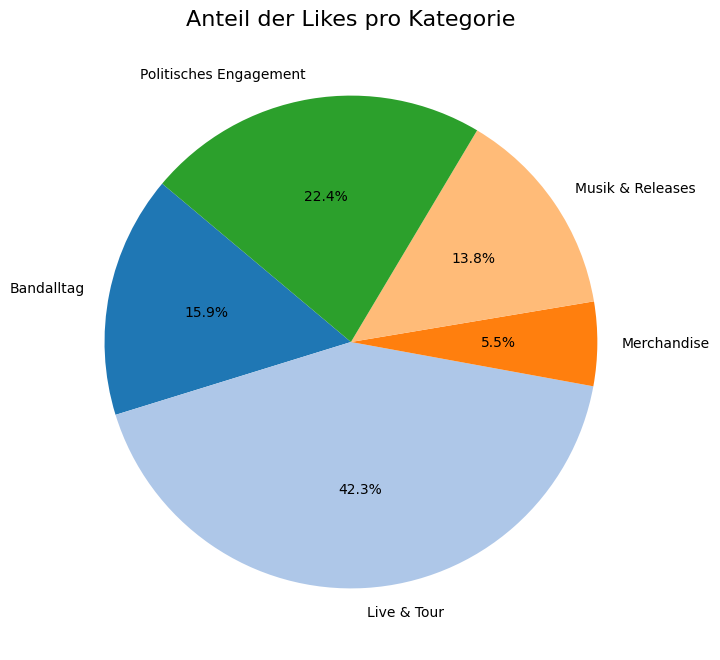

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Gruppiere Likes pro Kategorie
likes_per_category = post_df.groupby('category')['like_count'].sum().reset_index()

# Erzeuge eine Farbpalette mit so vielen Farben wie Kategorien
colors = plt.cm.tab20.colors[:len(likes_per_category)]  # tab20 hat 20 verschiedene Farben

# Plot
plt.figure(figsize=(8, 8))
plt.pie(
    likes_per_category['like_count'],
    labels=likes_per_category['category'],
    autopct='%1.1f%%',
    startangle=140,
    colors=colors  # verschiedene Farben
)
plt.title('Anteil der Likes pro Kategorie', fontsize=16)
plt.show()


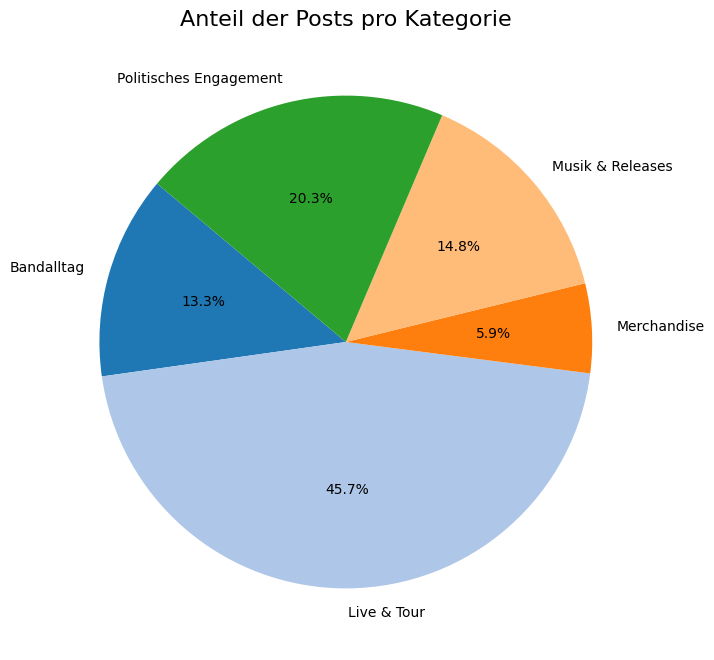

In [10]:
import matplotlib.pyplot as plt

# Erzeuge eine Farbpalette
colors = plt.cm.tab20.colors[:len(summary)]

# Plot
plt.figure(figsize=(8, 8))
plt.pie(
    summary['post_count'],
    labels=summary['category'],
    autopct='%1.1f%%',
    startangle=140,
    colors=colors
)
plt.title('Anteil der Posts pro Kategorie', fontsize=16)
plt.show()
